Loading and clearing data

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

try:
    df = pd.read_csv('OnlineRetail.csv', encoding = 'ISO-8859-1')
except:
    df = pd.read_csv('OnlineRetail.csv')
#for printing first 5 rows of dataframe
display(df.head())

#clearing data
print(f"size before cleaning: {df.shape}")

#delete rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])
#removing duplicates
df = df.drop_duplicates()

#clear refunds and free
df = df[(df['Quantity'] < 0) & (df['UnitPrice'] > 0)]

print(f"size after cleaning: {df.shape}")

#sum checks
df['TotalSum'] = df['Quantity'] * df['UnitPrice']




,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


size before cleaning: (541909, 8)
size after cleaning: (8872, 8)


Cohort analysis 

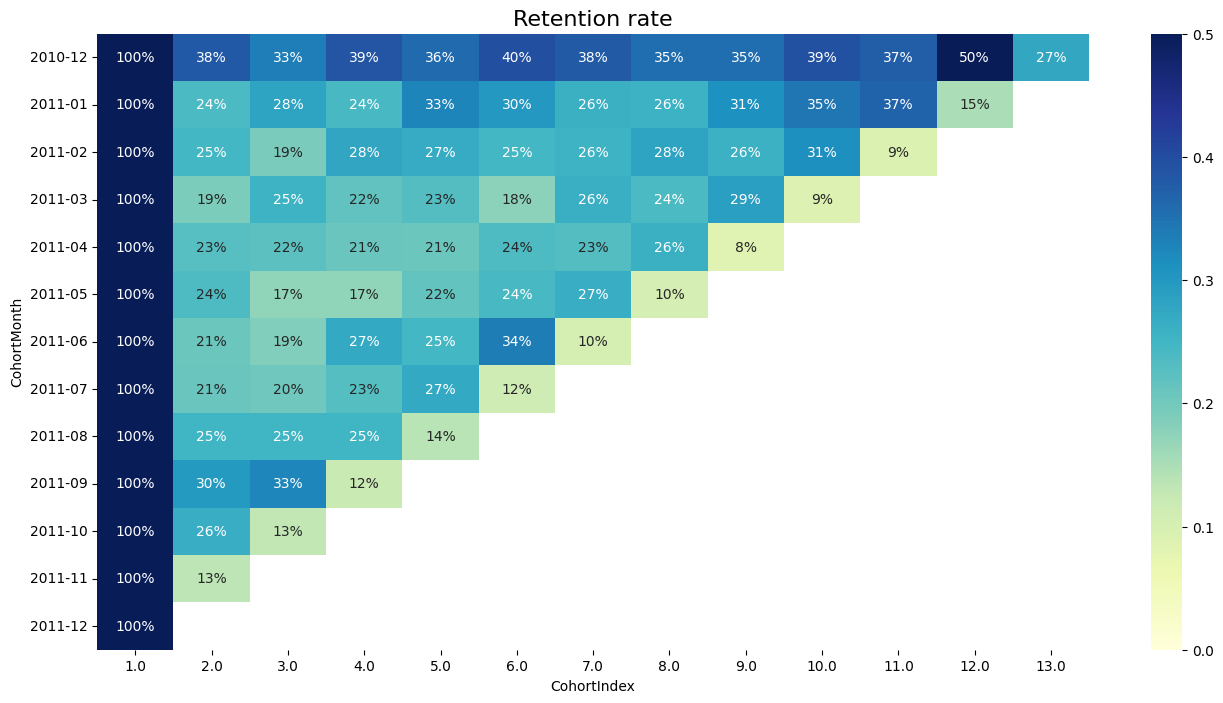

In [18]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

#find the month of the first purchasing for each user
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

#calculating diff in month for current and first purchase
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

years_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

#index cohort
df['CohortIndex'] = years_diff * 12 + month_diff + 1

#we count numbers of unique users in each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
#creating pivot table
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

#calculating retention rate % 
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.strftime('%Y-%m')
#vizualization heatmap
plt.figure(figsize=(16, 8))
plt.title('Retention rate', fontsize=16)
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='YlGnBu')
plt.show()